In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf # pip install tensorflow-macos
import os
tf.random.set_seed(1)

# What is and why use transfer learning?
- used in computer vision and NLP
- use someone else's fine-tuned model and apply it to your own situation
- leverage patterns learned in other data

# Downloading and preparing data for our first transfer learning model

- let's use 10% of training data from before to illustrate power of transfer learning
- use same data as standard CNN

In [2]:
import zipfile

zip_path = "10_food_classes_10_percent.zip"
if not os.path.isfile(zip_path):
    os.chdir("data")

zip_ref = zipfile.ZipFile(zip_path, "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Introducing Callbacks in TensorFlow and making a callback to track our models

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
- Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
- Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
- Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime as dt
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Exploring the TensorFlow Hub website for pretrained models
- we can explore pretrained models from [the tensorflow hub website](https://tfhub.dev/)
- decided to try [efficientnet b0 feature-vector model](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) and [resnet v2 50](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5)

# Building and compiling a TensorFlow Hub feature extraction model

In [8]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
def create_model(model_url, image_shape, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.
    image_shape (tuple): image shape

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name="feature_extraction_layer",
                                           input_shape=image_shape+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation="softmax", name="output_layer") # create our own output layer
  ])

  return model

Trying our function on resnet model

In [12]:
# Create model
resnet_model = create_model(resnet_url, image_shape=IMAGE_SHAPE, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


# Blowing our previous models out of the water with transfer learning

In [14]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name )

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230505-113806
Epoch 1/5


2023-05-05 11:38:06.907392: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 102s 4s/step - loss: 1.9096 - accuracy: 0.3827 - val_loss: 1.2026 - val_accuracy: 0.6068
Epoch 2/5
24/24 [==============================] - 123s 5s/step - loss: 0.9108 - accuracy: 0.7307 - val_loss: 0.8864 - val_accuracy: 0.7180
Epoch 3/5
24/24 [==============================] - 130s 6s/step - loss: 0.6440 - accuracy: 0.8200 - val_loss: 0.7755 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 132s 6s/step - loss: 0.5005 - accuracy: 0.8747 - val_loss: 0.7221 - val_accuracy: 0.7628
Epoch 5/5
24/24 [==============================] - 121s 5s/step - loss: 0.4147 - accuracy: 0.8947 - val_loss: 0.6959 - val_accuracy: 0.7728


# Plotting the loss curves of our ResNet feature extraction model

In [15]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Only works if accuracy is the metric the model is trained on
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

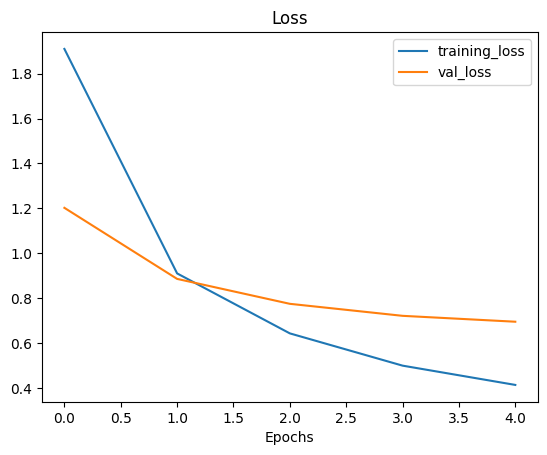

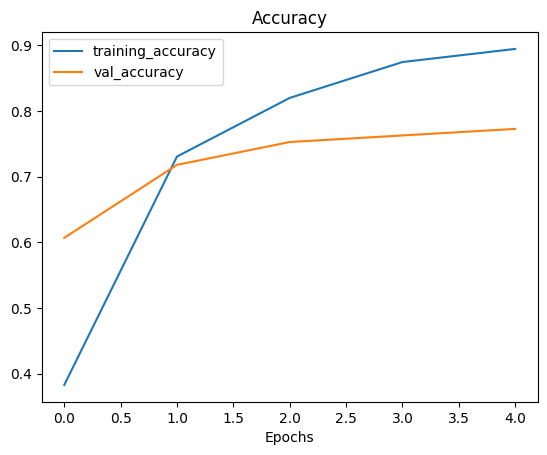

In [16]:
plot_loss_curves(resnet_history)

Much better than the CNN we designed ourselves

# Building and training a pre-trained EfficientNet model on our data

In [17]:
# Create model
efficientnet_model = create_model(efficientnet_url, image_shape=IMAGE_SHAPE, num_classes=train_data_10_percent.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [20]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                               experiment_name="efficientnetb0")]) # name )

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230505-115427
Epoch 1/5
24/24 [==============================] - 58s 2s/step - loss: 1.9310 - accuracy: 0.3653 - val_loss: 1.3435 - val_accuracy: 0.7048
Epoch 2/5
24/24 [==============================] - 55s 2s/step - loss: 1.1024 - accuracy: 0.7760 - val_loss: 0.8840 - val_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 49s 2s/step - loss: 0.7728 - accuracy: 0.8493 - val_loss: 0.6997 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 46s 2s/step - loss: 0.6158 - accuracy: 0.8680 - val_loss: 0.6097 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 45s 2s/step - loss: 0.5154 - accuracy: 0.8853 - val_loss: 0.5554 - val_accuracy: 0.8636


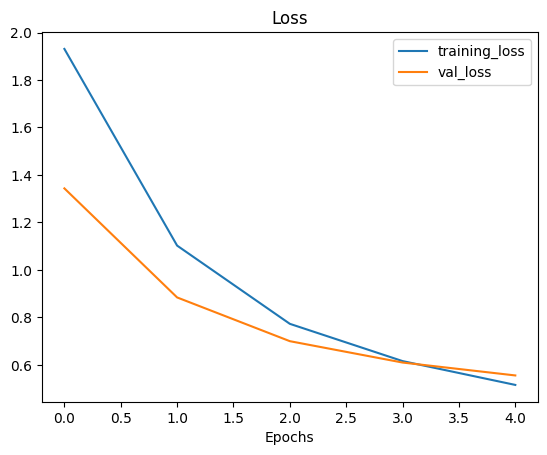

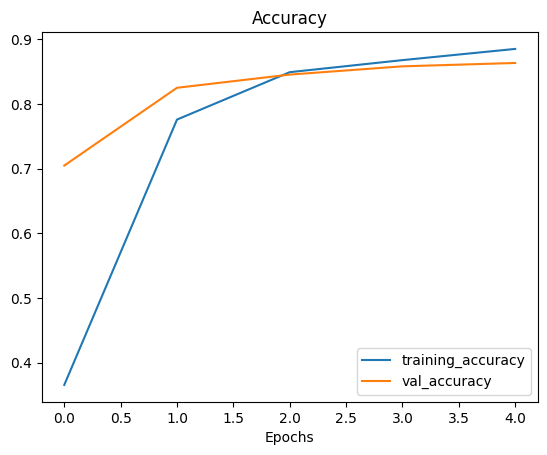

In [21]:
plot_loss_curves(efficientnet_history)

In [22]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


# Different Types of Transfer Learning

1. "As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.
- For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).
- This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.
2. Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
- For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.
- This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.
3. Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.
- This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

# Comparing Our Model's Results using TensorBoard

In [26]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot
# do --yes to auto accept


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) ^C
Traceback (most recent call last):
  File "/Users/NoahRipstein/PycharmProjects/Tensorflow tutorial att2/venv/bin/tensorboard", line 10, in <module>
    sys.exit(run_main())
  File "/Users/NoahRipstein/PycharmProjects/Tensorflow tutorial att2/venv/lib/python3.10/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
